<a href="https://colab.research.google.com/github/victordibia/taxi/blob/main/notebooks/taxi_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q geopandas contextily sklearn  

     |████████████████████████████████| 972kB 5.7MB/s 
     |████████████████████████████████| 143kB 19.6MB/s 
     |████████████████████████████████| 6.5MB 22.3MB/s 
     |████████████████████████████████| 14.8MB 489kB/s 
     |████████████████████████████████| 19.1MB 174kB/s 
     |████████████████████████████████| 675kB 52.1MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
ERROR: distributed 2021.2.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.2.0 has requirement dask>=2021.02.0, but you'll have dask 2.12.0 which is incompatible.
ERROR: dask-ml 1.8.0 has requirement scikit-learn>=0.23, but you'll have scikit-learn 0.22.2.post1 which is incompatible.


## Taxi Prediction 

Given data on NY Taxi trips explore the following:

- Visualizations and analytics that help end users build intuition on traffic patterns 
- Predict interesting outcomes given data available at test time. E.g. predict trip time or trip fare given date, start/end location etc. 


## Data Download
- Data Sourece - [NYC Taxi Cab](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- [Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)
- Download data for the last 2 years perhaps
- Train test construction
  - Load data for last 2 years
  - For each month, sample some values 
  - Concatenate samples
- Preprocess data
  - Remove trips with negative fare
  - Remove trips with negative duration
  - Remove trips with null values (we probably have enough data) 
  - Verify column types are correct i.e. categorical for categorical columns.

## Analytics
- Show plot of drop offs and/or pick ups 
- Aggregratedd traffic by time of day over the last month.
- Average time from one location to another? heatmap ?

### Pre-Computations
- From each start location, average time to all other end locations. For each hour during the day. 

## Tasks
- Predict trip time/fare. Given other data available at runtime 
- Predict demand for a given destination for a given time window during the day. Given time window and other factors (dayofweek, holiday, recent history etc) what is the demand for each location. 
## Modeling

- Explore multiple models
  - Naive bayes
  - Decision Tree
  - Random Forest
  - Gradient Boosted Trees
  - Neural Network

## Limitations

- Model limited to input ranges seen in training data e.g. if vendorid is used to train model and new vendorids are introduced, model will need to be updated. 
- External events or data may influence outcomes e.g. holidays, disasters, weather etc. We probably can integrate holiday data.
- The data does not give exact longitude/latitude of pickup and dropoff for privacy reasons. It only says the location ID (boroughs), so predictions are not granular/precise. 


## Download Data

- Ingest sample data from NY Yellow Cab Taxi Data

In [ ]:
import urllib.request 
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


def mkdir(dir_path):
  os.makedirs(dir_path, exist_ok=True)

def download_file(url, file_path):
  try:
    urllib.request.urlretrieve(url, file_path)
  except:
    print("Unable to download file", url)

def download_taxi_csv(year, month):
  file_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + str(year) + "-" + str(month) + ".csv" 
  file_path = "data/" + str(year)+ "_" + str(month) + ".csv"
  if not os.path.isfile(file_path):
    download_file(file_url, file_path )

def setup_plot():
  plt.rcParams["axes.grid.axis"] ="y"
  plt.rcParams["axes.grid"] = True
  plt.rcParams["legend.fontsize"] = 14
  plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
  plt.rcParams["xtick.labelsize"] = 15
  plt.rcParams["ytick.labelsize"]  = 15 

mkdir("data")
mkdir("data/zones")

In [ ]:
years = ["2020", "2019","2018"]
years = ["2020","2019"] 
years = [] 
months = [ str(x+1).zfill(2)  for x in range(12)]
data_date_range = [] 

for year in (years) :
  data_date_range = data_date_range + ([ [year,x] for x in months])

In [ ]:

months = [ str(x+1).zfill(2)  for x in range(12)]
data_date_range = [  ] 

for year in (years) :
  data_date_range = data_date_range + ([ [year,x] for x in months])

In [ ]:
# Download all CSV Files in Range
def download_all_files():
  print("Downloading CSV data") 
  for x in tqdm(data_date_range): 
    download_taxi_csv(x[0], x[1])

  # download shape files for plotting
  download_file("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv","data/zone_lookup.csv")
  download_file("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip","data/zones_shape.zip")

  #unzip shape files
  with zipfile.ZipFile("data/zones_shape.zip", 'r') as zip_ref:
      zip_ref.extractall("data/zones")
download_all_files()

In [ ]:
zd = pd.read_csv("data/zone_lookup.csv")
zdict = [ {zd.Zone[i] : str(zd.LocationID[i]) } for i in range(zd.shape[0]) ]

zdict = {}
for i in range(zd.shape[0]):
  zdict[zd.Zone[i]] = int(zd.LocationID[i])
import json
with open('zdict.json', 'w') as outfile:
    json.dump(zdict, outfile)

In [ ]:
## Build main data from samples 
## Extract sample from each downloaded file and fuse into one large file
all_data_path = "data/all_data_df.pickle"
all_data_df = None
def build_from_samples():
  if not os.path.isfile(all_data_path):
    sample_size = 200000
    df_holder = []
    for dr in tqdm(data_date_range):
      file_path = os.path.join("data", dr[0]+"_"+dr[1]+".csv") 
      if (os.path.isfile(file_path)): 
        df = pd.read_csv(file_path, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
        sample_size = sample_size if sample_size < df.shape[0] else df.shape[0]
        df_sample = df.copy().sample(sample_size, random_state=44)
        # df_sample = df 
        df_holder.append(df_sample) 
    all_data_df =  pd.concat(df_holder)
    print("Dataset size:", all_data_df.shape)
    all_data_df.to_pickle(all_data_path)
  else:
    all_data_df = pd.read_pickle(all_data_path)

build_from_samples()


In [ ]:
def feature_hist(data, title, xlabel, log_scale=False):
  plt.figure()
  fig, ax = plt.subplots()
  data.hist(bins=100, figsize=(14,6))
  plt.title(title);
  if log_scale:
    ax.set_yscale('log')
    plt.title(title + " (log scale)"  );
  plt.xlabel(xlabel)
  


def preprocess_data(df):
  cal = calendar()
  df["pickup_date_only"] = df['tpep_pickup_datetime'].dt.normalize()
  df["dropoff_date_only"] = df['tpep_dropoff_datetime'].dt.normalize()
  holidays = cal.holidays(start=df.pickup_date_only.min(), end=df.pickup_date_only.max())
  df['holiday'] = (df['pickup_date_only'].isin(holidays)).astype(int)
  
  df["trip_time"] =  (df.tpep_dropoff_datetime - df.tpep_pickup_datetime ).dt.total_seconds() / 60
  df["month"] = df.tpep_pickup_datetime.dt.month
  df["week"] = df.tpep_pickup_datetime.dt.isocalendar().week
  df["dayofweek"] = df.tpep_pickup_datetime.dt.dayofweek 
  df["isweekday"] = ((df.tpep_pickup_datetime.dt.dayofweek) // 5 == 1).astype(float)
  df["hour"] = df.tpep_pickup_datetime.dt.hour
  df["year"] = df.tpep_pickup_datetime.dt.year
  df = df[df.trip_time>=0] # drop rows with negative trip times
  df = df[df.trip_distance>=0] # drop rows with negative trip distance
  df = df[df.fare_amount>=0] # drop rows with negative fare 
  df = df.dropna(how = 'any', axis = 'rows')
  
  print(df.describe()) 
  return df


In [ ]:
all_data_df = pd.read_pickle(all_data_path) 
df = preprocess_data(all_data_df) 

           VendorID  passenger_count  ...          hour          year
count  1.120372e+06     1.120372e+06  ...  1.120372e+06  1.120372e+06
mean   1.623332e+00     1.414102e+00  ...  1.362765e+01  2.020000e+03
std    4.845507e-01     1.077410e+00  ...  5.431065e+00  2.597638e-02
min    1.000000e+00     0.000000e+00  ...  0.000000e+00  2.008000e+03
25%    1.000000e+00     1.000000e+00  ...  1.000000e+01  2.020000e+03
50%    2.000000e+00     1.000000e+00  ...  1.400000e+01  2.020000e+03
75%    2.000000e+00     1.000000e+00  ...  1.800000e+01  2.020000e+03
max    2.000000e+00     9.000000e+00  ...  2.300000e+01  2.020000e+03

[8 rows x 23 columns]


In [ ]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_date_only,dropoff_date_only,holiday,trip_time,month,week,dayofweek,isweekday,hour,year
1550159,1.0,2020-01-09 15:36:59,2020-01-09 15:48:28,1.0,1.70,1.0,N,239,151,1.0,10.0,2.5,0.5,2.65,0.0,0.3,15.95,2.5,2020-01-09,2020-01-09,0,11.483333,1,2,3,0.0,15,2020
3377359,2.0,2020-01-17 21:07:09,2020-01-17 21:09:00,2.0,0.49,1.0,N,229,233,1.0,3.5,0.5,0.5,1.46,0.0,0.3,8.76,2.5,2020-01-17,2020-01-17,0,1.850000,1,3,4,0.0,21,2020
1948304,1.0,2020-01-11 10:19:45,2020-01-11 10:24:53,1.0,0.90,1.0,N,161,142,1.0,5.5,2.5,0.5,1.32,0.0,0.3,10.12,2.5,2020-01-11,2020-01-11,0,5.133333,1,2,5,1.0,10,2020
5388638,2.0,2020-01-27 19:00:24,2020-01-27 19:12:09,1.0,1.30,1.0,N,234,249,1.0,9.0,1.0,0.5,2.66,0.0,0.3,15.96,2.5,2020-01-27,2020-01-27,0,11.750000,1,5,0,0.0,19,2020
5017507,2.0,2020-01-25 21:46:11,2020-01-25 21:52:47,1.0,0.66,1.0,N,79,107,1.0,6.0,0.5,0.5,1.96,0.0,0.3,11.76,2.5,2020-01-25,2020-01-25,0,6.600000,1,4,5,1.0,21,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78561,1.0,2020-06-06 23:08:54,2020-06-06 23:17:15,1.0,1.20,1.0,N,74,41,1.0,7.5,0.5,0.5,2.20,0.0,0.3,11.00,0.0,2020-06-06,2020-06-06,0,8.350000,6,23,5,1.0,23,2020
485379,2.0,2020-06-30 12:34:37,2020-06-30 12:44:12,1.0,1.53,1.0,N,186,137,1.0,8.0,0.0,0.5,3.39,0.0,0.3,14.69,2.5,2020-06-30,2020-06-30,0,9.583333,6,27,1,0.0,12,2020
66101,1.0,2020-06-05 19:41:43,2020-06-05 19:46:20,1.0,0.90,1.0,N,140,262,1.0,5.5,3.5,0.5,2.90,0.0,0.3,12.70,2.5,2020-06-05,2020-06-05,0,4.616667,6,23,4,0.0,19,2020
230076,1.0,2020-06-17 10:43:24,2020-06-17 10:54:00,1.0,3.10,1.0,N,79,140,1.0,11.0,2.5,0.5,2.85,0.0,0.3,17.15,2.5,2020-06-17,2020-06-17,0,10.600000,6,25,2,0.0,10,2020


In [ ]:
# df.hist(bins=30, figsize=(15, 10))

<Figure size 432x288 with 0 Axes>

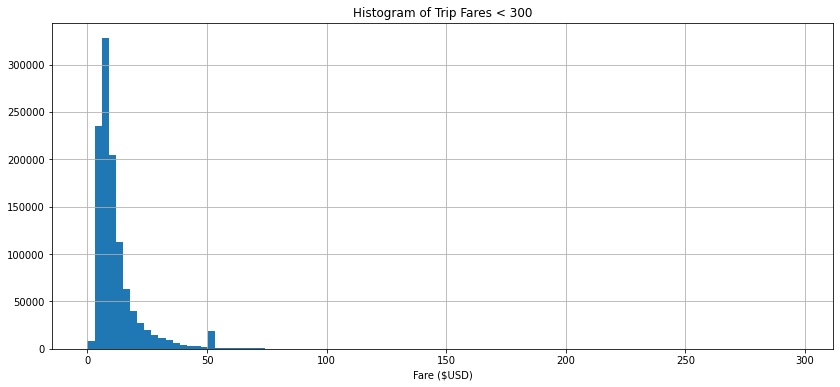

<Figure size 432x288 with 0 Axes>

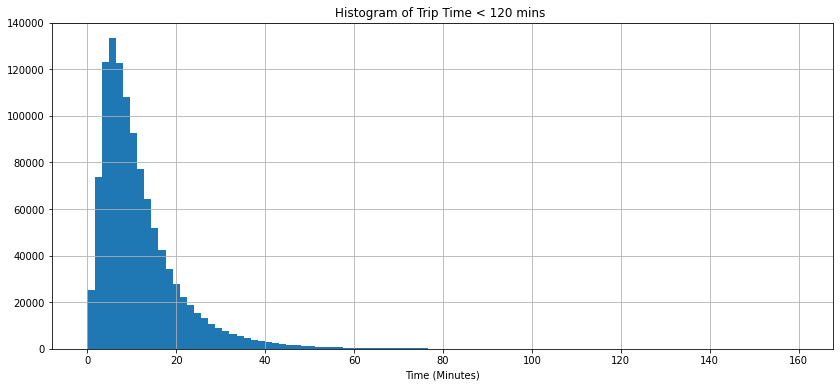

<Figure size 432x288 with 0 Axes>

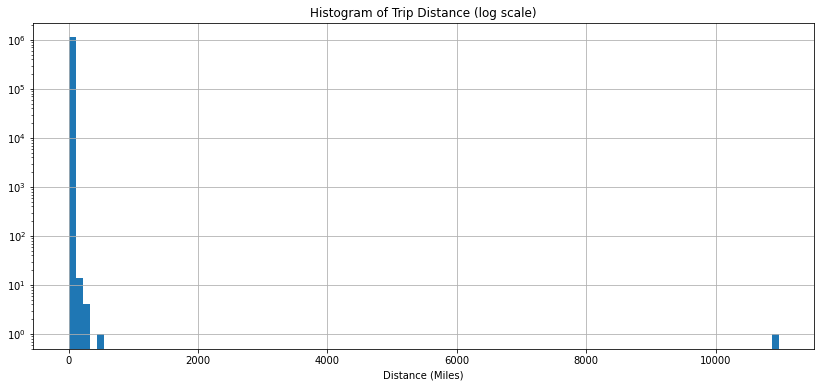

<Figure size 432x288 with 0 Axes>

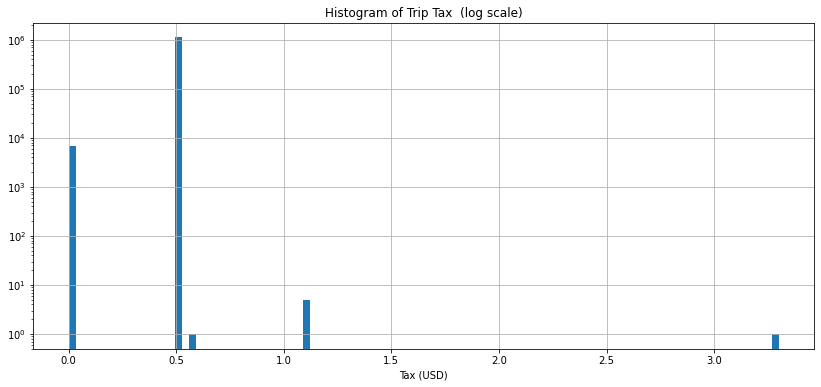

<Figure size 432x288 with 0 Axes>

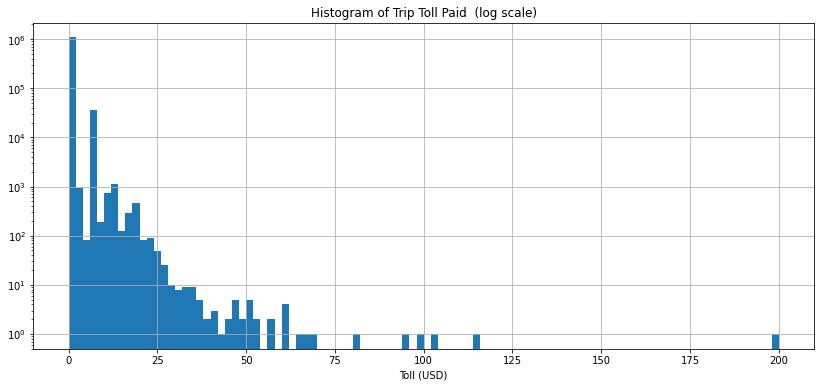

In [ ]:
feature_hist(df[df.fare_amount<300].fare_amount, 'Histogram of Trip Fares < 300', 'Fare ($USD)')
feature_hist(df[df.trip_time < (160)].trip_time, 'Histogram of Trip Time < 120 mins ', 'Time (Minutes)')
feature_hist(df.trip_distance, 'Histogram of Trip Distance', 'Distance (Miles)',  log_scale=True) 
feature_hist(df.mta_tax, 'Histogram of Trip Tax ', 'Tax (USD)', log_scale=True)
feature_hist(df.tolls_amount, 'Histogram of Trip Toll Paid ', 'Toll (USD)', log_scale=True)

These charts provide insights on how we might further clean the data to remove "outliers"?
- Trips with toll > 300 USD ?
- Trip MTA tax > 30 usd ?
- Distance > 150 miles?
- Fare Amount/Trip Time <= 0 or > 300

In [ ]:
# Additional Cleaning
df = df[df.trip_distance < 100]
df = df[df.trip_time < 100]
df = df[df.tolls_amount < 100]
df = df[df.fare_amount < 100]
df = df[df.mta_tax < 30]
df = df[df.year.isin(years)] # remove any years outside current consideration
df = df[df.passenger_count > 0] # remove trips with 0 or less passengers!
df.shape

(1089412, 28)

# Some Modelling 

Features available at trip initiation
- Date - day, week, year, hour, holiday or not 
- Pickup location, Drop off location 
- Payment type ?

Months 12 [ 1 12  7  2  3  6  4  5  8  9 11 10]


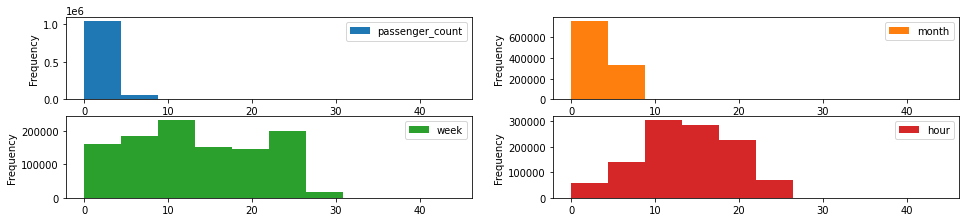

In [ ]:
# pd.to_datetime(df['tpep_pickup_datetime'], format='%Y%m%d', errors='coerce').dt.month
# plt.figure() 
print("Months", len(df.month.unique()), df.month.unique())
df_hist = df[["passenger_count" ,"month","week","hour"]].plot.hist(subplots=True, layout=(9,2 ),  figsize=(16,16), sharex=False, sharey=False) ;

In [ ]:
!mkdir taxi
!mkdir taxi/data 
df.to_csv("taxi/data/training.csv")

mkdir: cannot create directory ‘taxi’: File exists


In [ ]:
train_sample_size = 100000
categorical_features = ["isweekday","holiday", "dayofweek", "PULocationID", "DOLocationID"]  #["PULocationID", "DOLocationID"]
feature_list = ["passenger_count" ,"month","week","hour"]  
dfa = df 
dfa = df.sample(train_sample_size, random_state=42)

dfa[categorical_features] = dfa[categorical_features].astype("category") 
df_data = dfa[feature_list + categorical_features] 

data_ohe = pd.get_dummies(dfa[categorical_features])
df_data_ohe = pd.concat([dfa[feature_list],data_ohe],axis=1) 
# df_data_ohe = df_data
df_data_ohe.columns 

# df_data = dfa[feature_list ] 
# df_data[categorical_features] = df_data[categorical_features].astype("category") 
# df_data.month.unique()

Index(['passenger_count', 'month', 'week', 'hour', 'isweekday_0.0',
       'isweekday_1.0', 'holiday_0', 'holiday_1', 'dayofweek_0', 'dayofweek_1',
       ...
       'DOLocationID_256', 'DOLocationID_257', 'DOLocationID_258',
       'DOLocationID_259', 'DOLocationID_260', 'DOLocationID_261',
       'DOLocationID_262', 'DOLocationID_263', 'DOLocationID_264',
       'DOLocationID_265'],
      dtype='object', length=498)

In [ ]:
fare_labels = dfa.fare_amount
trip_time_labels = dfa.trip_time
fare_labels.shape, trip_time_labels.shape, df_data.shape, df_data_ohe.shape

((100000,), (100000,), (100000, 9), (100000, 498))

# Analytics and Plots

In [ ]:
import geopandas as gpd
import contextily as ctx

geo_df = gpd.read_file("data/zones/taxi_zones.shp") 
geo_df.to_crs(epsg=4326).to_file('data/zones/nyzones.geo.json', driver='GeoJSON')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


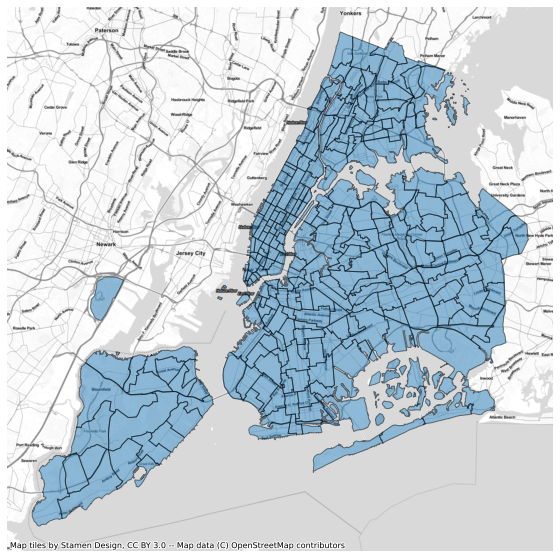

In [ ]:
geo_df = df.to_crs(epsg=3857)
ax = geo_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [ ]:
df

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-8258175.533 4967457.203, -8258179.5..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-8217980.622 4959237.286, -821..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-8220713.534 4993383.154, -8220638.4..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-8234500.227 4971984.094, -8234502.1..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-8257036.109 4948033.095, -8256954.5..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-8221063.636 4999130.459, -8221175.1..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-8226705.594 4977119.879, -8226674.0..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-8239125.774 4968930.646, -8239119.5..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-8231389.789 4980365.995, -823..."
